In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Let's save attention maps for ClassSet8 (NewC43Added) Layer4 fold-2 model sorted by type of error.

Layer 4 is overall best, and looking at training logs - Fold-2 have shown highest F1 score on validation set.

In [2]:
# !pip install torchsummary

In [3]:
#IMPORTS
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image
import os
import io
import base64

from matplotlib.pyplot import imshow

In [4]:
import sys
sys.path.append(os.path.abspath("../../skin_cancer_nas")) # go to parent dir
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/data/torch_generator"))
sys.path.append(os.path.abspath("/mnt/skin_cancer_nas/nas/darts_torch"))

sys.path.append('/mnt')
sys.path.append('/mnt/skin_cancer_nas')
sys.path.append('/mnt/skin_cancer_nas/data/torch_generator')
from skin_cancer_nas.data.torch_generator import generator as data_gen
from skin_cancer_nas.data.torch_generator import base_classes
from skin_cancer_nas.data.torch_generator.config import *

from nas.darts_torch import *
import cv2



# ROOT_PATHS = [  Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/checkyourskin'),
#                 Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/loc'),
#                 Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels/loc_old_colored')]

# CLS1 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43', 'd03', 'd03.9'], class_name='Melanoma_like_lesions', int_label=0)
# CLS2 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22', 'd81', 'l81.2','l81.4', 'q82.5'], class_name='Pigmented_benign', int_label=1)
# CLS3 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d86.3', 'l21', 'l57', 'l57.0', 'l82', 'l85', 'l85.1', 'l85.5', 'l85.8', 'q80'], class_name='Keratin_lesions', int_label=2)
# CLS4 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c44', 'c46', 'd09'], class_name='Nonmelanoma_skin_cancer', int_label=3)
# CLS5 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['a63', 'd18', 'd21.9', 'd48', 'l92', 'l94.2', 'l98.8', 'pxe', 'b07', 'ada', 'l57.9', 'l98.9'], class_name='Other', int_label=4)

ROOT_PATHS = [  Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels_MAN_CORRECTED/checkyourskin'),
            Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels_MAN_CORRECTED/loc'),
            Path('/mnt/data/interim/_melanoma_20200728_REGISTERED_OCV_WHITE_Split_Channels_MAN_CORRECTED/loc_old_colored'),
            Path('/mnt/data/interim/_melanoma_20200728_2__checkyourskin_c43_NoDuplicates')]

CLS1 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43', 'd03', 'd03.9'], class_name='Melanoma_like_lesions', int_label=0)
CLS2 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22', 'l81.2','l81.4', 'q82.5'], class_name='Pigmented_benign', int_label=1)   #'d81', 
CLS3 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d86.3', 'l21', 'l57', 'l57.0', 'l82', 'l85', 'l85.1', 'l85.5', 'l85.8', 'q80'], class_name='Keratin_lesions', int_label=2)
CLS4 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c44', 'c46', 'd09'], class_name='Nonmelanoma_skin_cancer', int_label=3)
CLS5 = ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['a63', 'd18', 'd21.9', 'd48', 'l92', 'l94.2', 'l98.8', 'pxe', 'b07', 'ada', 'l57.9', 'l98.9'], class_name='Other', int_label=4)

CLASSES_SET_1 = [CLS1, CLS2]
CLASSES_SET_2 = [CLS1, CLS2, CLS3]
CLASSES_SET_3 = [CLS1, CLS2, CLS3, CLS4]
CLASSES_SET_4 = [ \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=1) \
]
CLASSES_SET_5 = [ \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=1), \
    ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['l82'], class_name='Keratin lesion', int_label=2) \
]
CLASSES_SET_6 = [ \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c43'], class_name='Melanoma', int_label=0), \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['c44'], class_name='NonMelanomaCancer', int_label=1), \
   ClassesDefinition(root_folders_list=ROOT_PATHS, diagnoses_names_list=['d22'], class_name='Nevuss', int_label=2) \
]

CLASSES_SET_8 = [CLS1, CLS2, CLS3, CLS4, CLS5]

VALID_CHANNELS = ['r-r', 'ir-r', 'g-g', 'uv-0-r', 'uv-0-g', 'white-g']

IMG_WIDTH = 128
IMG_HEIGHT = 128
VALUE_MISSING = 0
MISSING_CH_IMG = np.ones((IMG_HEIGHT, IMG_WIDTH)) * VALUE_MISSING

In [5]:
import logging
logger = logging.getLogger('skin_cancer_nas__darts__attention_notebook')

### Load model

In [6]:
# Load model
device = 'cpu'

model = torch.load("/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-2/final_model1.pt")
model.to(device)
for param in model.parameters():
    param.requires_grad = False

In [17]:
import json

log_file_path = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-2/model1.log.txt"
with open(log_file_path) as fp: 
    for line in fp: 
        if "2020-10-29 18:12:08,163,163 nni-darts INFO partition->defaultdict(<class 'list'>, " in line:
            part_str = line.replace("2020-10-29 18:12:08,163,163 nni-darts INFO partition->defaultdict(<class 'list'>, ", '')[:-2]
            part_str = part_str.replace("'", '"')
#             print(part_str)
            part_dict = json.loads(part_str)


### Data preparation

In [19]:
_, labels = data_gen.train_val_split(val_ratio=0.1, classes_list=CLASSES_SET_8)
partition = part_dict
classes_num = len(CLASSES_SET_8)


def get_input_output_from_path(sample_path, labels):
    '''
    Generates one sample of data
    '''
    try:
        # logger.info('Sample path={}'.format(sample_path))
        x_out = _convert_img_to_array(sample_path)
        x_out = x_out.astype('float32')
        x_out /= 255

        X = torch.as_tensor(x_out)
        y = labels[str(sample_path)]

        X = X.to(device)
        y = torch.tensor(y).to(device)
        return X, y
    except Exception as e: 
        logger.info('Something went wrong at path={}, e={}'.format(sample_path, e))


def _convert_img_to_array(sample_path):
    '''Converts n grayscale images to 3D array with n channels'''
    x_array = []
    for channel in VALID_CHANNELS:
        channel_path = os.path.join(sample_path, channel)
        if not os.path.exists(channel_path):
            x_array.append(MISSING_CH_IMG)
            continue
        image = os.listdir(channel_path)
        if not image:
            x_array.append(MISSING_CH_IMG)
            continue
        full_image_path = os.path.join(channel_path, image[0])
        img = cv2.imread(full_image_path, flags=cv2.IMREAD_GRAYSCALE)
        if img is None:
            x_array.append(MISSING_CH_IMG)
            continue
        else:
            shape = img.shape
            # logger.info(shape)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_CUBIC)

        x_array.append(img)

    return np.stack(x_array, axis=0)

! IMPORTANT ! - for now we don't have any image transformations (like normalization), but once they will be - they have to be added here!

In [20]:
X, y = get_input_output_from_path(sample_path=partition['validation'][0], labels=labels)
# X.requires_grad_()

### Calculate saliency (attention) maps

In [21]:
def get_saliencies(X, model, classes_num):
    '''
    inputs:
        X: - image torch tensor (preprocessed if needed)
        model: torch model
        classes_num: number of classes (last layer size)
    returns:
        saliencies: list of activations (6, img_width, img_height), 6 channels as we have four inputs, these can be summed up for visualization
        score_max_index: winning score index (index of saliency map (and neuron), that had highest output)
    '''
    # Copy input
    X_orig = X.detach().clone()
    
    # we would run the model in evaluation mode
    model.eval()
    saliencies = []
    for score_indx in range(classes_num):
        X = X_orig.detach().clone()
        # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
        X.requires_grad_()

        '''
        forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
        and we also don't need softmax, we need scores, so that's perfect for us.
        '''
        scores = model(X.unsqueeze(0))

        # Get the index corresponding to the maximum score and the maximum score itself.
        score_max_index = scores.argmax()
        score_to_analize = scores[0, score_indx]

        '''
        backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
        score_to_analize with respect to nodes in the computation graph
        '''
        score_to_analize.backward()

        '''
        Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
        R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
        across all colour channels.
        '''
        # saliency, _ = torch.max(X.grad.data.abs(), dim=0)
    #     saliency = torch.sum(X.grad.data.abs(), dim=0)
        saliencies.append(X.grad.data.abs().detach().numpy())
        
    return saliencies, score_max_index.detach().numpy().item()

In [22]:
saliencies, score_max_index = get_saliencies(X, model, classes_num=5)

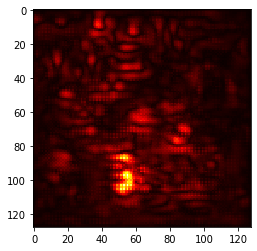

In [23]:
imshow(np.sum(saliencies[0], axis=0), cmap=plt.cm.hot)

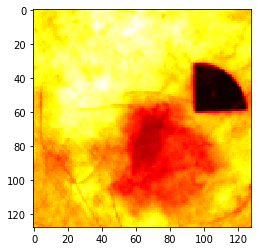

In [24]:
imshow(np.sum(X.numpy(), axis=0), cmap=plt.cm.hot)

In [25]:
# Gather list of input 'image' matrices, labels and paths (for titles)
X_list = []
y_list = []  # y_true
paths_list = []
saliencies_list = []
score_max_index_list = []  # y_pred
len_val = len(partition['validation'])
print(len_val)
for i in tqdm(range(len_val)):
    sample_path = partition['validation'][i]
    _X, _y = get_input_output_from_path(sample_path=sample_path, labels=labels)
    X_list.append(_X)
    y_list.append(_y)
    paths_list.append(sample_path)
    
    saliencies, score_max_index = get_saliencies(_X, model, classes_num=classes_num)
    saliencies_list.append(saliencies)
    score_max_index_list.append(score_max_index)

280


In [ ]:
# Now we want to display SUMMED saliency map and SUMMED input

In [26]:
output_root_folder = '/mnt/data/interim/saliency_debug/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_ClassSet8_ManCorected_registered_fold-2_V2'

i = 0

class_names_dict = {0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC', 4:'Other'}

for x, y, path, sal, score_max in tqdm(zip(X_list, y_list, paths_list, saliencies_list, score_max_index_list)):
    
    stacked_input_img = np.sum(x.numpy(), axis=0)
    stacked_sal_img = np.sum(sal[score_max], axis=0) 
    
    stacked_input_img = cv2.normalize(stacked_input_img, stacked_input_img, 1, 254, cv2.NORM_MINMAX)
    stacked_sal_img = cv2.normalize(stacked_sal_img, stacked_sal_img, 1, 254, cv2.NORM_MINMAX)
    
#     print(y.numpy())
#     print(score_max)
    
    subfolder_name = class_names_dict[int(str(y.numpy()))] + '_classified_as_' + class_names_dict[score_max]
    
    output_folder = os.path.join(output_root_folder, subfolder_name)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    
    cv2.imwrite(os.path.join(output_folder, '{}_stacked_input_image.png'.format(i)), stacked_input_img)
    cv2.imwrite(os.path.join(output_folder, '{}_stacked_saliency_map.png'.format(i)), stacked_sal_img)
    
    X_ = x.numpy()
    for ch in range(X_.shape[0]):
        cv2.imwrite(os.path.join(output_folder, '{}_input_image_channel{}.png'.format(i, ch)), cv2.normalize(X_[ch, :, :], X_[ch, :, :], 1, 254, cv2.NORM_MINMAX))
        
    S_ = sal[score_max]
    for ch in range(S_.shape[0]):
        cv2.imwrite(os.path.join(output_folder, '{}_saliency_map_channel{}.png'.format(i, ch)), cv2.normalize(S_[ch, :, :], S_[ch, :, :], 1, 254, cv2.NORM_MINMAX))
    
    i = i + 1

## Now let's create visualizations as Ilze asked - two rows with text predicted class / actual class

In [27]:
output_root_folder = '/mnt/data/interim/saliency_debug/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_4lrs_2oct_ClassSet8_ManCorected_registered_fold-2_V3'

i = 0

class_names_dict = {0:'MLL', 1:'PBL', 2:'KL', 3:'NonMSC', 4:'Other'}

for x, y, path, sal, score_max in tqdm(zip(X_list, y_list, paths_list, saliencies_list, score_max_index_list)):
    
#     stacked_input_img = x.numpy().transpose(2,0,1).reshape(x.numpy().shape[1],-1)  #np.sum(x.numpy(), axis=0)
#     stacked_sal_img = sal[score_max].transpose(2,0,1).reshape(sal[score_max].shape[1],-1) #np.sum(sal[score_max], axis=0) 
    
#     stacked_input_img = cv2.normalize(stacked_input_img, stacked_input_img, 1, 254, cv2.NORM_MINMAX)
#     stacked_sal_img = cv2.normalize(stacked_sal_img, stacked_sal_img, 1, 254, cv2.NORM_MINMAX)
    
#     total_img = np.vstack((stacked_input_img, stacked_sal_img))
#     total_img = cv2.putText(total_img, "Class {}".format(class_names_dict[int(str(y.numpy()))], (10,40), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))
#     total_img = cv2.putText(total_img, "Predicted as {}".format(class_names_dict[score_max], (10,60), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
    subfolder_name = class_names_dict[int(str(y.numpy()))] + '_classified_as_' + class_names_dict[score_max]
    
    output_folder = os.path.join(output_root_folder, subfolder_name)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    stacked_input_img = x.numpy().transpose(2,0,1).reshape(x.numpy().shape[1],-1)  #np.sum(x.numpy(), axis=0)
    stacked_sal_img = sal[score_max].transpose(2,0,1).reshape(sal[score_max].shape[1],-1) #np.sum(sal[score_max], axis=0) 

    stacked_input_img = cv2.normalize(cv2.UMat(stacked_input_img), cv2.UMat(stacked_input_img), 1, 254, cv2.NORM_MINMAX)
    stacked_sal_img = cv2.normalize(cv2.UMat(stacked_sal_img), cv2.UMat(stacked_sal_img), 1, 254, cv2.NORM_MINMAX)

    total_img = np.vstack((stacked_input_img.get(), stacked_sal_img.get()))
    total_img = np.array(total_img)
    total_img = cv2.cvtColor(total_img,cv2.COLOR_GRAY2RGB)
    total_img = cv2.putText(cv2.UMat(total_img), "Actual class: {}".format(class_names_dict[int(str(y.numpy()))]), (10,20), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,250), thickness=1)
    total_img = cv2.putText(total_img, "Predicted class: {}".format(class_names_dict[score_max]), (10,45), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(0,0,250), thickness=1)
    total_img = total_img.get()
    
    
    cv2.imwrite(os.path.join(output_folder, '{}_combined_saliency_image.png'.format(i)), total_img)
    
    i = i + 1

In [128]:
stacked_input_img = x.numpy().transpose(2,0,1).reshape(x.numpy().shape[1],-1)  #np.sum(x.numpy(), axis=0)
stacked_sal_img = sal[score_max].transpose(2,0,1).reshape(sal[score_max].shape[1],-1) #np.sum(sal[score_max], axis=0) 

stacked_input_img = cv2.normalize(cv2.UMat(stacked_input_img), cv2.UMat(stacked_input_img), 1, 254, cv2.NORM_MINMAX)
stacked_sal_img = cv2.normalize(cv2.UMat(stacked_sal_img), cv2.UMat(stacked_sal_img), 1, 254, cv2.NORM_MINMAX)

total_img = np.vstack((stacked_input_img.get(), stacked_sal_img.get()))
total_img = np.array(total_img)
total_img = cv2.cvtColor(total_img,cv2.COLOR_GRAY2RGB)
total_img = cv2.putText(cv2.UMat(total_img), "Actual class: {}", (10,20), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,250), thickness=1)
total_img = cv2.putText(total_img, "Predicted class: {}", (10,45), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(0,0,250), thickness=1)
total_img = total_img.get()

In [129]:
cv2.imwrite('/mnt/notebooks/tmp_combined_saliency_v2.png', total_img)

True

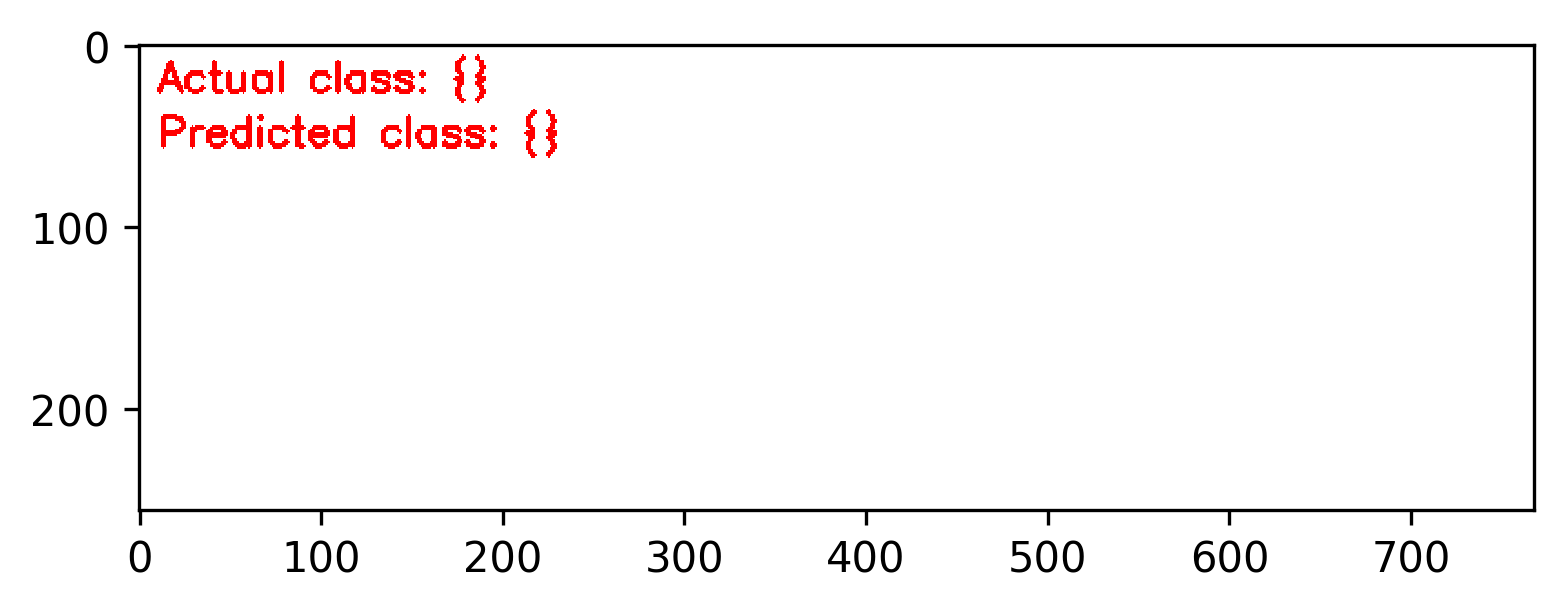

In [116]:
fig = plt.figure(figsize=(6, 6), dpi=300)
imshow(total_img)

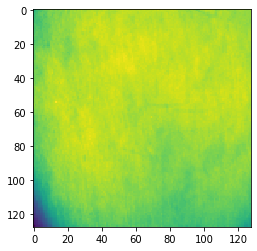

In [63]:
imshow(x.numpy()[0,:,:])

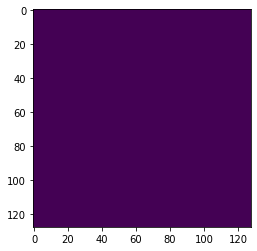

In [67]:
imshow(x.numpy()[5,:,:])

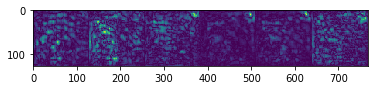

In [71]:
imshow(sal[score_max].transpose(2,0,1).reshape(sal[score_max].shape[1],-1))